In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
sys.path.append('C:\\Program Files\\lib\\site-packages')
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def date_align(dfA, datatitleA, dfB, datatitleB):
    i = 0
    j = 0
    new_df = pd.DataFrame()
    date_list = []
    A_list = []
    B_list = []
    while i < len(dfA['pd_date']) and j < len(dfB['pd_date']):
        if dfA['pd_date'][i] < dfB['pd_date'][j]:
            date_list.append(dfA['pd_date'][i])
            A_list.append(dfA[datatitleA][i])
            B_list.append(np.nan)
            i += 1
        elif dfA['pd_date'][i] == dfB['pd_date'][j]:
            date_list.append(dfA['pd_date'][i])
            A_list.append(dfA[datatitleA][i])
            B_list.append(dfB[datatitleB][j])
            i += 1
            j += 1
        elif dfA['pd_date'][i] > dfB['pd_date'][j]:
            date_list.append(dfB['pd_date'][j])
            A_list.append(np.nan)
            B_list.append(dfB[datatitleB][j])
            j += 1
    while j < len(dfB['pd_date']):
        date_list.append(dfB['pd_date'][j])
        A_list.append(np.nan)
        B_list.append(dfB[datatitleB][j])
        j += 1
    while i < len(dfA['pd_date']):
        date_list.append(dfA['pd_date'][i])
        A_list.append(dfA[datatitleA][i])
        B_list.append(np.nan)
        i += 1
    new_df['pd_date'] = date_list
    new_df[datatitleA] = A_list
    new_df[datatitleB] = B_list
    return new_df

def create_diff_vector(start_df, datatitle, datetitle):
    diff = []
    diff_perc = []
    diff.append(np.nan)
    diff_perc.append(np.nan)
    for i in range(1, len(start_df[datetitle])):
        diff.append(start_df[datatitle][i] - start_df[datatitle][i - 1])
        diff_perc.append((start_df[datatitle][i] - start_df[datatitle][i - 1]) / start_df[datatitle][i])
    return diff, diff_perc

def remove_rows(df, num_rows):
    df=df.drop(df.index[0:num_rows])
    df=df.reset_index()
    df=df.drop(['index'], axis=1)
    return df

In [3]:
os.chdir('C://Users//nschm/economic_data/')

cpi_data=pd.read_csv('CPIAUCSL.csv')
unemp=pd.read_csv('Unemploy_rate.csv')
cpi_data['pd_date']=pd.to_datetime(cpi_data['DATE'])
unemp['pd_date']=pd.to_datetime(unemp['DATE'])

# rows removed to start around 1947 (same as CPI)
ppi_data=pd.read_csv('PPIACO.csv')
ppi_data['pd_date']=pd.to_datetime(ppi_data['DATE'])
ppi_data=remove_rows(ppi_data, 408)

ppi_idc=pd.read_csv('PPIIDC.csv')
ppi_idc['pd_date']=pd.to_datetime(ppi_idc['DATE'])
ppi_idc=remove_rows(ppi_idc, 420)


# from http://www.nfib-sbet.org/indicators/
small_bis=pd.read_excel('small_bus_optimism.xlsx')
small_bis['pd_date']=pd.to_datetime(small_bis['Month/Year'])
small_bis=small_bis[::-1]
small_bis=small_bis.reset_index()
small_bis=small_bis.drop(['index'], axis=1)

combined_df = date_align(cpi_data, 'CPIAUCSL', unemp, 'UNRATE')
[cpi_diff, cpi_diff_perc]=create_diff_vector(combined_df, 'CPIAUCSL', 'pd_date')
[unemp_diff, unemp_diff_perc]=create_diff_vector(combined_df, 'UNRATE', 'pd_date')
combined_df['cpi_diff']=cpi_diff
combined_df['cpi_diff_perc']=cpi_diff_perc
combined_df['unemp_diff']=unemp_diff
combined_df['unemp_diff_perc']=unemp_diff_perc

temp_combined_df = date_align(cpi_data, 'CPIAUCSL', ppi_data, 'PPIACO')
combined_df['PPI']=temp_combined_df['PPIACO']
[ppi_diff, ppi_diff_perc]=create_diff_vector(combined_df, 'PPI', 'pd_date')
combined_df['ppi_diff']=ppi_diff
combined_df['ppi_diff_perc']=ppi_diff_perc

temp_combined_df = date_align(cpi_data, 'CPIAUCSL', small_bis, 'Small Business Optimism')
combined_df['small_bis_opt']=temp_combined_df['Small Business Optimism']
[sb_diff, sb_diff_perc]=create_diff_vector(combined_df, 'small_bis_opt', 'pd_date')
combined_df['sb_diff']=sb_diff
combined_df['sb_diff_perc']=sb_diff_perc

temp_combined_df = date_align(cpi_data, 'CPIAUCSL', ppi_idc, 'PPIIDC')
combined_df['PPIIDC']=temp_combined_df['PPIIDC']
[ppiidc_diff, ppiidc_diff_perc]=create_diff_vector(combined_df, 'PPIIDC', 'pd_date')
combined_df['ppiidc_diff']=sb_diff
combined_df['ppiidc_diff_perc']=sb_diff_perc

pce=pd.read_csv('PCE.csv')
pce['pd_date']=pd.to_datetime(pce['DATE'])
temp_combined_df = date_align(cpi_data, 'CPIAUCSL', pce, 'PCE')
combined_df['PCE']=temp_combined_df['PCE']
[pce_diff, pce_diff_perc]=create_diff_vector(combined_df, 'PCE', 'pd_date')
combined_df['pce_diff']=pce_diff
combined_df['pce_diff_perc']=pce_diff_perc

price_oil=pd.read_csv('POILBREUSDM.csv')
price_oil['pd_date']=pd.to_datetime(price_oil['DATE'])
temp_combined_df = date_align(cpi_data, 'CPIAUCSL', price_oil, 'POILBREUSDM')
combined_df['price_oil']=temp_combined_df['POILBREUSDM']

combined_df['price_oil'][846]=48.66
combined_df['price_oil'][847]=50.94
combined_df['price_oil'][848]=53.95
combined_df['price_oil'][849]=55.92
combined_df['price_oil'][850]=60.93
combined_df['price_oil'][851]=62.19

[price_oil_diff, price_oil_diff_perc]=create_diff_vector(combined_df, 'price_oil', 'pd_date')
combined_df['price_oil_diff']=price_oil_diff
combined_df['price_oil_diff_perc']=price_oil_diff_perc

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [4]:
days_to_average=6
dataset=pd.DataFrame()

col_to_use=[]

col_title_vector=['cpi', 'ppi', 'unemp', 'sb', 'price_oil', 'ppiidc', 'pce']
for i in col_title_vector:
    exec('prev_diff_'+i+'=[]')
    exec('twoday_prev_'+i+'=[]')
    exec('thrday_prev_'+i+'=[]')
    exec('prev_'+i+'=[]')
    exec('curr_'+i+'=[]')
    exec('mean_'+i+'=[]')
    exec('col_to_use.append(\'prev_diff_'+i+'\')')
    exec('col_to_use.append(\'twoday_prev_'+i+'\')')
    exec('col_to_use.append(\'thrday_prev_'+i+'\')')
    exec('col_to_use.append(\'prev_'+i+'\')')
    exec('col_to_use.append(\'curr_'+i+'\')')
    exec('col_to_use.append(\'mean_'+i+'\')')
    #468 is Jan 1986, good for SBO
    for j in range(480, len(combined_df['pd_date'])):
        exec('prev_diff_'+i+'.append(combined_df[\''+i+'_diff_perc\'][j-1]-combined_df[\''+i+'_diff_perc\'][j-2])')
        exec('twoday_prev_'+i+'.append(combined_df[\''+i+'_diff_perc\'][j-2])')
        exec('thrday_prev_'+i+'.append(combined_df[\''+i+'_diff_perc\'][j-3])')
        exec('prev_'+i+'.append(combined_df[\''+i+'_diff_perc\'][j-1])')
        exec('curr_'+i+'.append(combined_df[\''+i+'_diff_perc\'][j])')
        exec('mean_'+i+'.append(np.nanmean(combined_df[\''+i+'_diff_perc\'][j-days_to_average:j-1]))')
    
cpi_norm_value=np.nanmax(np.abs(curr_cpi))
for i in col_title_vector:
    exec('prev_diff_'+i+'=prev_diff_'+i+'/np.nanmax(np.abs(prev_diff_'+i+'))')
    exec('twoday_prev_'+i+'=twoday_prev_'+i+'/np.nanmax(np.abs(twoday_prev_'+i+'))')
    exec('thrday_prev_'+i+'=thrday_prev_'+i+'/np.nanmax(np.abs(thrday_prev_'+i+'))')
    exec('prev_'+i+'=prev_'+i+'/np.nanmax(np.abs(prev_'+i+'))')
    exec('curr_'+i+'=curr_'+i+'/np.nanmax(np.abs(curr_'+i+'))')
    exec('mean_'+i+'=mean_'+i+'/np.nanmax(np.abs(mean_'+i+'))')
    exec('dataset[\'prev_diff_'+i+'\']=prev_diff_'+i)
    exec('dataset[\'twoday_prev_'+i+'\']=twoday_prev_'+i)
    exec('dataset[\'thrday_prev_'+i+'\']=thrday_prev_'+i)
    exec('dataset[\'prev_'+i+'\']=prev_'+i)
    exec('dataset[\'curr_'+i+'\']=curr_'+i)
    exec('dataset[\'mean_'+i+'\']=mean_'+i)
    

dates=[]
for i in range(480, len(combined_df['pd_date'])):
    dates.append(combined_df['pd_date'][i])
dataset['pd_date']=dates
final_values=dataset[-1:]
dataset=dataset[:-1]

average error in prediction:
[0.0011867523963847914, 0.0011540311897811776, 0.0013341325925255189, 0.0011719581307982042, 0.0012895809919647241]
0.00122729106029
maximum error in prediction:
0.00867349240979
average predicted value:
[0.0023277019393760185, 0.0025522946876164699, 0.0030161707496309232, 0.0029181935933014496, 0.0025785327853213979]
0.00267857875105
number of misses above .5%:
4
Linear Regression Feature Weights
0.097174952269 prev_diff_cpi
-0.0140400839539 twoday_prev_cpi
-0.0801058658734 thrday_prev_cpi
0.051057530999 prev_cpi
0.150437126228 mean_cpi
-0.00116123634747 prev_diff_ppi
-0.0342631866045 twoday_prev_ppi
0.0106343087716 thrday_prev_ppi
-0.0354518203406 prev_ppi
0.4507124142 curr_ppi
-0.106947184413 mean_ppi
-0.00582382366666 prev_diff_unemp
0.0304618530005 twoday_prev_unemp
0.0056570750374 thrday_prev_unemp
0.0232151633244 prev_unemp
0.00722408199652 curr_unemp
0.00203375609007 mean_unemp
0.00924515530934 prev_diff_sb
-0.0118743220867 twoday_prev_sb
-0.0178087

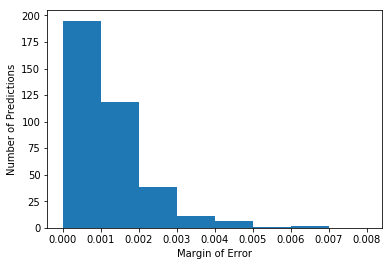

In [5]:
predicted_value='curr_cpi'

temp=list(col_to_use)
temp.remove('curr_cpi')
#temp.remove('curr_ppi')
#temp.remove('prev_diff_ppi')
#temp.remove('curr_pce')
#temp.remove('curr_sb')
#temp.remove('prev_diff_pce')

col_names=temp

#col_names=col_to_use.remove(predicted_value)

#col_names=col_to_use

model=LinearRegression(normalize=False)
#model=RandomForestRegressor(n_estimators=45, criterion='mae', oob_score=True)
#model=GradientBoostingRegressor(learning_rate=.05)

total_error_dist=[]

mean_error=[]
mean_values=[]

temp=list(range(5))
for i in list(range(5)):
    temp=list(range(5))
    temp.remove(i)
    test=dataset[i::5]
    training_setup=[dataset[temp[0]::5], dataset[temp[1]::5], dataset[temp[2]::5], dataset[temp[3]::5]]
    training=pd.concat(training_setup)

    fit=model.fit(training[col_names], training[predicted_value])
    lr_prediction=fit.predict(test[col_names])
    
    mean_error.append(np.mean(np.abs(lr_prediction-test[predicted_value]))*cpi_norm_value)
    
    total_error_dist.append(np.abs(lr_prediction-test[predicted_value])*cpi_norm_value)
    
    mean_values.append(np.mean(np.abs(test[predicted_value]))*cpi_norm_value)
    
print('average error in prediction:')
print(mean_error)
print(np.mean(mean_error))

print('maximum error in prediction:')
print(np.max(pd.concat(total_error_dist)))

print('average predicted value:')
print(mean_values)
print(np.mean(mean_values))

print('number of misses above .5%:')
print(sum(pd.concat(total_error_dist)>.005))

print('Linear Regression Feature Weights')
for i in range(0, len(test[col_names].keys())): print(fit.coef_[i], test[col_names].keys()[i])
#for i in range(0, len(test[col_names].keys())): print(fit.feature_importances_[i], test[col_names].keys()[i])

plt.hist(pd.concat(total_error_dist), bins=[0, .001, .002,  .003, .004, .005, .006, .007, .008])
plt.xlabel('Margin of Error')
plt.ylabel('Number of Predictions')
plt.savefig('Lin_Reg_error')
plt.show()

average error in prediction:
[0.001529642018033465, 0.0013795593512980024, 0.0014210784583638223, 0.0012530712729189987, 0.0015359253306847388]
0.00142385528626
maximum error in prediction:
0.00812426186998
average predicted value:
[0.0023277019393760185, 0.0025522946876164699, 0.0030161707496309232, 0.0029181935933014496, 0.0025785327853213979]
0.00267857875105
number of misses above .5%:
8


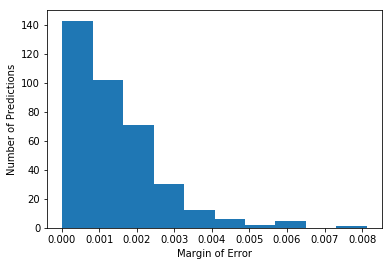

In [6]:
predicted_value='curr_cpi'

col_names=list(col_to_use)
col_names.remove('curr_cpi')

total_error_dist=[]

mean_error=[]
mean_values=[]

batches=30

temp=list(range(5))
for i in list(range(5)):
    temp=list(range(5))
    temp.remove(i)
    test=dataset[i::5]
    training_setup=[dataset[temp[0]::5], dataset[temp[1]::5], dataset[temp[2]::5], dataset[temp[3]::5]]
    training=pd.concat(training_setup)

    model=Sequential()
    s='relu'
    model.add(Dense(40, activation=s, input_dim=len(col_names)))
    model.add(Dropout(.1))
    model.add(Dense(40, activation=s))
    model.add(Dropout(.1))
    model.add(Dense(1, activation='linear'))
    #keras.optimizers.RMSprop(lr=.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer='rmsprop')

    model.fit(training[col_names], training[predicted_value], batch_size=batches, epochs=500, verbose=0)

    nn_prediction=model.predict(test[col_names])
    nn_prediction=np.ndarray.tolist(nn_prediction)
    nn_prediction=[float(nn_prediction[i][0]) for i in range(len(nn_prediction))]
    
    mean_error.append(np.mean(np.abs(nn_prediction-test[predicted_value]))*cpi_norm_value)
    
    total_error_dist.append(np.abs(nn_prediction-test[predicted_value])*cpi_norm_value)
    
    mean_values.append(np.mean(np.abs(test[predicted_value]))*cpi_norm_value)

print('average error in prediction:')
print(mean_error)
print(np.mean(mean_error))

print('maximum error in prediction:')
print(np.max(pd.concat(total_error_dist)))

print('average predicted value:')
print(mean_values)
print(np.mean(mean_values))

print('number of misses above .5%:')
print(sum(pd.concat(total_error_dist)>.005))

#print(model.layers[0].get_weights()[0])

plt.hist(pd.concat(total_error_dist))
plt.xlabel('Margin of Error')
plt.ylabel('Number of Predictions')
plt.savefig('NN_error')
plt.show()

In [7]:
cols_to_use=[]
for i in final_values.keys():
    if not final_values[i].isnull().bool():
        cols_to_use.append(i)

print(cols_to_use)
        
predicted_value='curr_cpi'

try: 
    cols_to_use.remove(predicted_value)
except:
    pass
cols_to_use.remove('pd_date')

model=LinearRegression(normalize=False)

fit=model.fit(dataset[cols_to_use], dataset[predicted_value])
lr_prediction=fit.predict(final_values[cols_to_use])

print('Linear Regression Prediction:')
print(lr_prediction)

batches=10

model=Sequential()
s='linear'
model.add(Dense(40, activation=s, input_dim=len(cols_to_use)))
model.add(Dropout(.1))
model.add(Dense(40, activation=s))
model.add(Dropout(.1))
model.add(Dense(1, activation=s))
#keras.optimizers.RMSprop(lr=.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

model.fit(dataset[cols_to_use], dataset[predicted_value], batch_size=batches, epochs=500, verbose=0)

nn_prediction=model.predict(final_values[cols_to_use])

print('Neural Network Prediction:')
print(nn_prediction)

print(final_values['pd_date'])

['prev_diff_cpi', 'twoday_prev_cpi', 'thrday_prev_cpi', 'prev_cpi', 'curr_cpi', 'mean_cpi', 'prev_diff_ppi', 'twoday_prev_ppi', 'thrday_prev_ppi', 'prev_ppi', 'curr_ppi', 'mean_ppi', 'prev_diff_unemp', 'twoday_prev_unemp', 'thrday_prev_unemp', 'prev_unemp', 'mean_unemp', 'prev_diff_sb', 'twoday_prev_sb', 'thrday_prev_sb', 'prev_sb', 'mean_sb', 'prev_diff_price_oil', 'twoday_prev_price_oil', 'thrday_prev_price_oil', 'prev_price_oil', 'mean_price_oil', 'prev_diff_ppiidc', 'twoday_prev_ppiidc', 'thrday_prev_ppiidc', 'prev_ppiidc', 'mean_ppiidc', 'prev_diff_pce', 'twoday_prev_pce', 'thrday_prev_pce', 'prev_pce', 'mean_pce', 'pd_date']
Linear Regression Prediction:
[ 0.16570489]
Neural Network Prediction:
[[ 0.14919116]]
372   2018-01-01
Name: pd_date, dtype: datetime64[ns]
